In [12]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from nni.nas.pytorch import mutables
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
from copy import deepcopy
from torchviz import make_dot
from collections import OrderedDict
from pathlib import Path
from nni.nas.pytorch import enas
import sys
import re
import scipy.sparse as sp

project_path = Path.cwd().parent.parent
data_path = project_path / 'data'
src_path = project_path / 'python' / 'src'
sys.path.append(str(src_path))

from graph_generator import GraphGenerator
import utils as g

# remove scientific notation
np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The nni package from microsoft allow us to define the search space of our NAS algorithm (see this [link](https://github.com/microsoft/nni/blob/master/docs/en_US/NAS/NasGuide.md) for more details on the API of nni).

In [ ]:
def reward_accuracy(output, target, topk=(1,)):
    batch_size = target.size(0)
    _, predicted = torch.max(output.data, 1)
    return (predicted == target).sum().item() / batch_size

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Output size must match, need to play with kernel_size and striding
        self.conv1 = mutables.LayerChoice([
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=3),
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=5, stride=3),
        ])
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        # declaring that there is exactly one candidate to choose from
        # search strategy will choose one or None
        self.skipcon1 = mutables.InputChoice(n_candidates=1, key='relu2->relu3')
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=1, stride=1)
        self.relu3 = nn.ReLU()
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        self.maxpool3x3 = nn.MaxPool2d(kernel_size=3)
        self.output = nn.Linear(in_features=256, out_features=10)
            

    def forward(self, x):
        x = self.relu1(self.batchnorm1(self.conv1(x)))
        x = self.relu2(self.batchnorm2(self.conv2(x)))
        
        # Open skipconnection
        x1 = self.skipcon1([x])
        
        x = self.relu3(self.batchnorm3(self.conv3(x)))
        
        # A possible connection from conv2 is added to the output of conv3
        if x1 is not None:
            x += x1
        
        x = self.maxpool3x3(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        output = F.log_softmax(x, dim=1)
        return output

Then, we do a single forward pass to generate the computationel graph for the network.

In [ ]:
use_cuda = False

batch_size = 128
seed = 42
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

model = Net()
mean, std = 0.1307, 0.3081

dataset_train = CIFAR10(root=str(data_path), train=True, download=True, transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))                   
                             ]))
dataset_valid = CIFAR10(root=str(data_path), train=False, download=True, transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.05, momentum=0.9, weight_decay=1.0E-4)

# use NAS here
def top1_accuracy(output, target):
    # this is the function that computes the reward, as required by ENAS algorithm
    batch_size = target.size(0)
    _, predicted = torch.max(output.data, 1)
    return (predicted == target).sum().item() / batch_size

def metrics_fn(output, target):
    # metrics function receives output and target and computes a dict of metrics
    return {"acc1": reward_accuracy(output, target)}

trainer = enas.EnasTrainer(model,
                           loss=criterion,
                           metrics=metrics_fn,
                           reward_function=top1_accuracy,
                           optimizer=optimizer,
                           batch_size=batch_size,
                           num_epochs=1,  # 10 epochs
                           dataset_train=dataset_train,
                           dataset_valid=dataset_valid,
                           log_frequency=10)  # print log every 10 steps
trainer.train()  # training
trainer.export(file="./final_architecture.json")  # export the final architecture to file

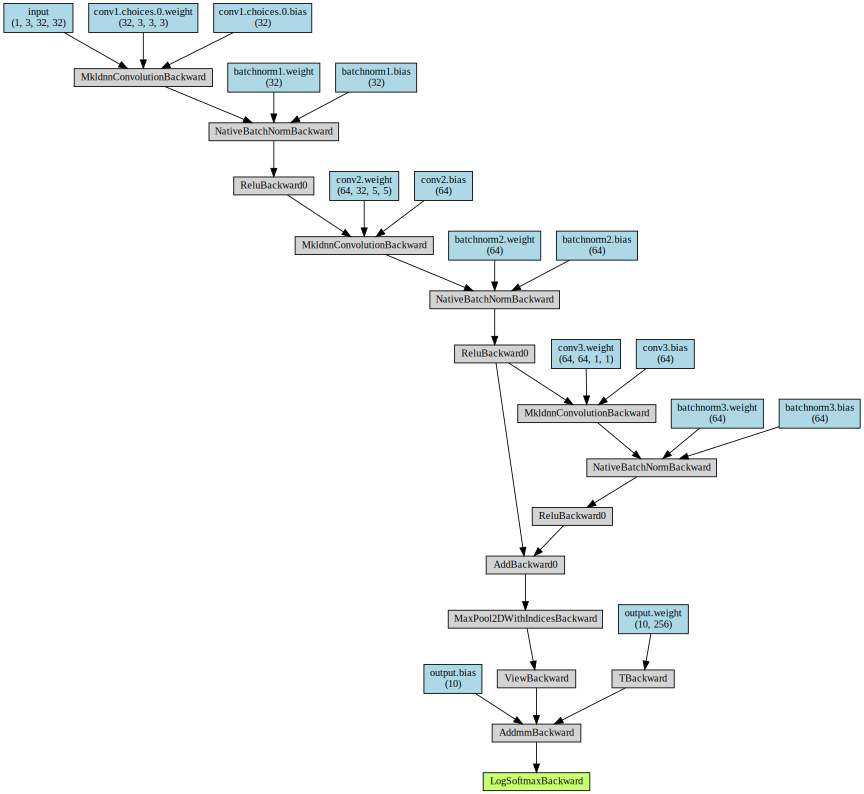

In [5]:
x = torch.Tensor(dataset_train.data[0].reshape((1, 3, 32, 32))).requires_grad_(True)
y = model(x)
y.requires_grad_(True)
dot = make_dot(y, params=dict([('output', y)] + list(model.named_parameters()) + [('input', x)]))
dot

### Graph representation

__Goal__: In this section, we want to parse a graph generated by pytorch. Pytorch provided a graph as a list of module but in order to manipulate this graph that represent a network architecture, we need to have acces to its basical attributes such as :
- the adjacency matrix
- the list of nodes
- A matrix that encode paramaters of each graph's nodes.

__Experimentation__: Code functions that enable user to parse a list of pytorch modules in order to get basical graph's attributs.

In [6]:
# Example of a list of modules
modules = [('input', x.shape)] + list(model.named_modules())[1:] + [('output', y.shape)]
modules

[('input', torch.Size([1, 3, 32, 32])),
 ('conv1', conv1 (LayerChoice1)),
 ('conv1.choices',
  ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3))
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3))
  )),
 ('conv1.choices.0', Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3))),
 ('conv1.choices.1', Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3))),
 ('relu1', ReLU()),
 ('batchnorm1',
  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('conv2', Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))),
 ('relu2', ReLU()),
 ('batchnorm2',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('skipcon1', skipcon1 (relu2->relu3)),
 ('conv3', Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))),
 ('relu3', ReLU()),
 ('batchnorm3',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('maxpool3x3',
  MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)),
 ('out

In [17]:
graph_generator = GraphGenerator()
graph_generator.parse_modules(modules[:10])
graph = graph_generator.generate()

In [18]:
graph

{0: ('input', 'torch.Size([1, 3, 32, 32])'),
 1: array(['conv1.choices',
        'Conv2d(3, 32, kernel_size=(5, 5), stride=(3, 3))'], dtype='<U48'),
 2: ('relu1', 'ReLU()'),
 3: ('batchnorm1',
  'BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)'),
 4: ('conv2', 'Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))'),
 5: ('relu2', 'ReLU()'),
 6: ('batchnorm2',
  'BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)')}

In [19]:
parameters = ['kernel_size', 'stride', 'momentum', 'eps',
              'track_running_stats', 'affine', 'ceil_mode', 'padding', 'bias', 'dilatation']
parameters_to_id = {parameter: i for i,parameter in enumerate(parameters)}

graph = g.get_graph_attribut(graph, symetric=False, dict_params=parameters_to_id)
graph

{'adjacency': <7x7 sparse matrix of type '<class 'numpy.float32'>'
 	with 6 stored elements in COOrdinate format>,
 'edges': array([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6]]),
 'features': array([[0.     , 5.     , 0.     , 0.     , 5.     , 0.     , 0.     ],
        [0.     , 3.     , 0.     , 0.     , 1.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.1    , 0.     , 0.     , 0.1    ],
        [0.     , 0.     , 0.     , 0.00001, 0.     , 0.     , 0.00001],
        [0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 1.     ],
        [0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]]),
 'nodes': {0: ['torch.size'],
  1:

__Results__: By using the same API that `scikit-network`, we store our graph's attribut in an instance of `Bunch` class.

### Graph embedding

__Goal__: Obtain a low dimensional space representing the graphs. This space need to be continuous to enable the use of gradient based optimisation techniques. 

__Experimentation__: Experiment several graph embedding techniques such as :
- matrix factorization (SVD)
- GAE

In [ ]:
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.embedding import SVD, cosine_modularity
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
import matplotlib.pyplot as plt

In [ ]:
graph = karate_club(metadata=True)

In [ ]:
from sknetwork.embedding import SVD, cosine_modularity
svd = SVD(3)
embedding = svd.fit_transform(np.array(adj.todense()))
embedding.shape

In [ ]:
plt.scatter(embedding[:, 1], embedding[:, 2])

In [ ]:
graph

In [ ]:
svd = SVD(3)
embedding = svd.fit_transform(adj)
embedding.shape

In [ ]:
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG
from sknetwork.data import parse_tsv

In [ ]:
image = svg_graph(adj)
SVG(image)

In [ ]:
graph = parse_tsv(str(data_path / 'test_graph.csv'), delimiter=',', weighted=False, directed=True)

In [ ]:
adj = np.array(graph.adjacency.todense())
adj

In [ ]:
image = svg_graph(adj)
SVG(image)

In [ ]:
graph.names

In [ ]:
graph

In [ ]:
from sknetwork.data import erdos_renyie, block_model, linear_graph, cyclic_graph, linear_digraph, cyclic_digraph

In [ ]:
graph = linear_digraph(8, metadata=True)
adjacency = graph.adjacency
position = graph.position

In [ ]:
graph

In [ ]:
from scipy import sparse

row = np.array(
        [0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5,
         6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9,
         10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13])
col = np.array(
        [3, 10, 3, 12, 9, 0, 1, 7, 11, 12, 2, 5, 9, 2, 4, 8, 9,
         0, 13, 1, 2, 3, 8, 11, 12, 0, 1, 4, 5, 7, 10, 11, 2, 4,
         0, 3, 8, 11, 12, 0, 1, 3, 10, 12, 1, 3, 4, 7, 6, 8])
adjacency = sparse.csr_matrix((np.ones(len(row), dtype=int), (row, col)), shape=(14, 14))

In [ ]:
adjacency.todense()

In [ ]:
col.shape

In [ ]:
np.ones(len(row), dtype=int)